# Final Project using Logistic Regression

### 1. Choose Dataset

- We went with using our previous dataset, "College Student Placment Factors" by Salim. 

## 2. Data Analysis Technique

- We chose Logistic Regression as our main technique and supplemented with k means clustering which is on the other jupyter notebook. we want to be able to predict the placement of a student as well as which variables have a signficant effect on the placement variables.

## 3. Data Exploration and Preparation

- We will perform data preparation by first taking a look if there are anything out of place. Then we scan for outliers and decide what to do with them like either ignore them or perform data capping.

### Imports and Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from scipy.stats import chi2
from sklearn.metrics import roc_auc_score, roc_curve

### Data Inspection



In [27]:

try:
    df = pd.read_csv('college_student_placement_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure the file 'college_student_placement_dataset.csv' is in the same directory as your notebook.")
    



outlier_count = df[df['CGPA'] > 10.0].shape[0]
print(f"Number of CGPA entries above 10.0: {outlier_count}")

df.loc[df['CGPA'] > 10.0, 'CGPA'] = 10.0
print("CGPA column has been successfully capped at 10.0.")

new_max = df['CGPA'].max()
print(f"New maximum CGPA after capping: {new_max:.1f}")
from sklearn.model_selection import train_test_split
binary_map = {'Yes': 1, 'No': 0}

df['Internship_Experience_Binary'] = df['Internship_Experience'].map(binary_map)

df['Placement_Binary'] = df['Placement'].map(binary_map)


print("\n--- Data Information (df.info()) ---")
df.info()

print("\n--- Statistical Summary (df.describe()) ---")
df.describe()

Dataset loaded successfully!
Number of CGPA entries above 10.0: 249
CGPA column has been successfully capped at 10.0.
New maximum CGPA after capping: 10.0

--- Data Information (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   College_ID                    10000 non-null  object 
 1   IQ                            10000 non-null  int64  
 2   Prev_Sem_Result               10000 non-null  float64
 3   CGPA                          10000 non-null  float64
 4   Academic_Performance          10000 non-null  int64  
 5   Internship_Experience         10000 non-null  object 
 6   Extra_Curricular_Score        10000 non-null  int64  
 7   Communication_Skills          10000 non-null  int64  
 8   Projects_Completed            10000 non-null  int64  
 9   Placement                     10000 non-null 

,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Internship_Experience_Binary,Placement_Binary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99.471800,7.535673,7.528296,5.546400,4.970900,5.561800,2.513400,0.396400,0.165900
std,15.053101,1.447519,1.462917,2.873477,3.160103,2.900866,1.715959,0.489174,0.372009
min,41.000000,5.000000,4.540000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,89.000000,6.290000,6.290000,3.000000,2.000000,3.000000,1.000000,0.000000,0.000000
50%,99.000000,7.560000,7.550000,6.000000,5.000000,6.000000,3.000000,0.000000,0.000000
75%,110.000000,8.790000,8.770000,8.000000,8.000000,8.000000,4.000000,1.000000,0.000000
max,158.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,1.000000,1.000000


### IQR 

In [28]:

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"\n{column}:")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"Number of outliers: {len(outliers)}")
    
    return outliers

# Check for each feature
columns_to_check = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 
                    'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

for col in columns_to_check:
    detect_outliers_iqr(df, col)
    


IQ:
Lower bound: 57.5, Upper bound: 141.5
Number of outliers: 61

Prev_Sem_Result:
Lower bound: 2.5400000000000014, Upper bound: 12.539999999999997
Number of outliers: 0

CGPA:
Lower bound: 2.5700000000000007, Upper bound: 12.489999999999998
Number of outliers: 0

Academic_Performance:
Lower bound: -4.5, Upper bound: 15.5
Number of outliers: 0

Extra_Curricular_Score:
Lower bound: -7.0, Upper bound: 17.0
Number of outliers: 0

Communication_Skills:
Lower bound: -4.5, Upper bound: 15.5
Number of outliers: 0

Projects_Completed:
Lower bound: -3.5, Upper bound: 8.5
Number of outliers: 0


### Scaling

In [29]:
# BEFORE scaling
print("BEFORE SCALING:")
print(df[['IQ', 'CGPA', 'Projects_Completed']].head(10))
print("\nStatistics BEFORE:")
print(df[['IQ', 'CGPA', 'Projects_Completed']].describe())

features_to_scale = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance',
                     'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# AFTER scaling
print("\n" + "="*50)
print("AFTER SCALING:")
print(df_scaled[['IQ', 'CGPA', 'Projects_Completed']].head(10))
print("\nStatistics AFTER:")
print(df_scaled[['IQ', 'CGPA', 'Projects_Completed']].describe())

BEFORE SCALING:
    IQ  CGPA  Projects_Completed
0  107  6.28                   4
1   97  5.37                   0
2  109  5.83                   1
3  122  5.75                   1
4   96  7.69                   2
5   96  5.32                   0
6  123  6.58                   2
7  111  8.76                   2
8   92  6.33                   5
9  108  8.60                   1

Statistics BEFORE:
                 IQ          CGPA  Projects_Completed
count  10000.000000  10000.000000        10000.000000
mean      99.471800      7.528296            2.513400
std       15.053101      1.462917            1.715959
min       41.000000      4.540000            0.000000
25%       89.000000      6.290000            1.000000
50%       99.000000      7.550000            3.000000
75%      110.000000      8.770000            4.000000
max      158.000000     10.000000            5.000000

AFTER SCALING:
         IQ      CGPA  Projects_Completed
0  0.500135 -0.853335            0.866381
1 -0.164214 -1.

In [30]:
from sklearn.model_selection import train_test_split

# 1. Define the 'features' variable (needed for Cell 4)
# We reuse the list 'features_to_scale' you defined in Cell 3
features = features_to_scale

# 2. Define X (Features) and y (Target)
# Note: We use your 'df_scaled' variable here, NOT 'X_scaled'
X = df_scaled[features]
y = df['Placement_Binary']

# 3. Create the Train/Test Split
# This creates the variables 'X_train' and 'y_train' that Cell 4 is missing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Success! Training and Testing data created.")
print(f"Training Data: {X_train.shape[0]} students")
print(f"Testing Data: {X_test.shape[0]} students")

Success! Training and Testing data created.
Training Data: 8000 students
Testing Data: 2000 students


## 4. Logistic Regression Modelling

### Part 1: Train Model

Model Accuracy: 90.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1674
           1       0.75      0.61      0.67       326

    accuracy                           0.90      2000
   macro avg       0.84      0.79      0.81      2000
weighted avg       0.90      0.90      0.90      2000



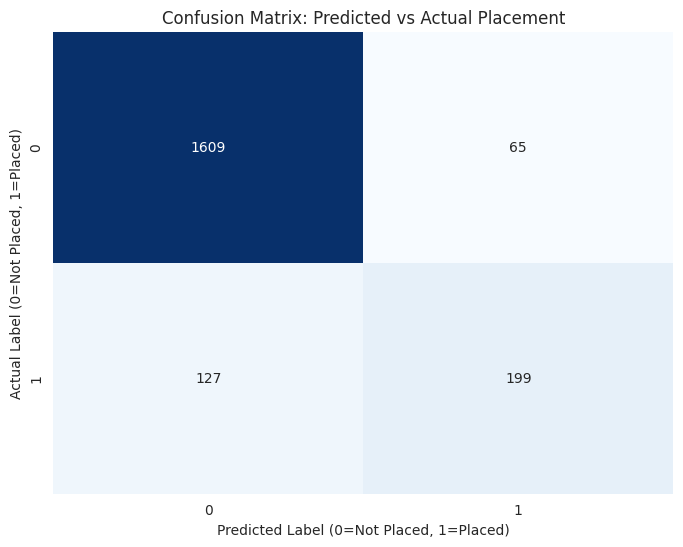

In [31]:
# 1. Initialize and Train the Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# 2. Make Predictions
y_pred = log_reg.predict(X_test)

# 3. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 4. Visualizing the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Predicted vs Actual Placement')
plt.xlabel('Predicted Label (0=Not Placed, 1=Placed)')
plt.ylabel('Actual Label (0=Not Placed, 1=Placed)')
plt.show()

Part 2: Feature Importance

/tmp/ipykernel_37275/2641701073.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients, x='Importance', y='Feature', palette='viridis')


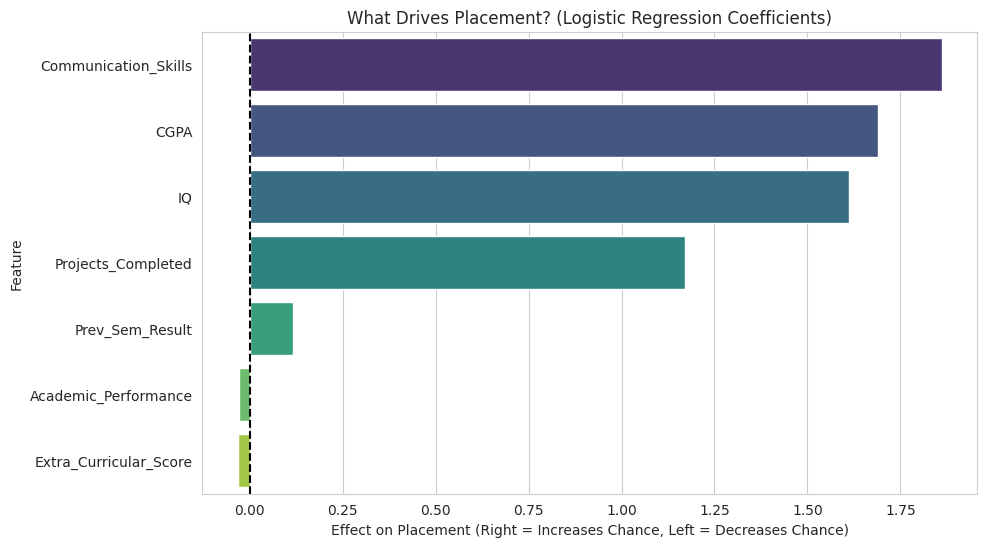

Top 3 Factors helping placement:
                Feature  Importance
5  Communication_Skills    1.862104
2                  CGPA    1.688748
0                    IQ    1.612853

Top 3 Factors hurting placement:
                  Feature  Importance
1         Prev_Sem_Result    0.115973
3    Academic_Performance   -0.028629
4  Extra_Curricular_Score   -0.032943


In [32]:
# 1. Extract Coefficients (Weights)
coefficients = pd.DataFrame({
    'Feature': features,
    'Importance': log_reg.coef_[0]
})

# 2. Sort by Importance (Absolute value isn't needed here, we want to see + vs -)
coefficients = coefficients.sort_values(by='Importance', ascending=False)

# 3. Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Importance', y='Feature', palette='viridis')
plt.title('What Drives Placement? (Logistic Regression Coefficients)')
plt.xlabel('Effect on Placement (Right = Increases Chance, Left = Decreases Chance)')
plt.axvline(x=0, color='black', linestyle='--') # Add a center line for 0
plt.show()

# 4. Print the top drivers for your report
print("Top 3 Factors helping placement:")
print(coefficients.head(3))
print("\nTop 3 Factors hurting placement:")
print(coefficients.tail(3))

### Chi-Squared Test for Model Significance

In [37]:
# 1. Calculate Log-Likelihood of YOUR Fitted Model
# We get the probabilities for the training set
probs_fitted = log_reg.predict_proba(X_train)
# log_loss calculates 'negative log-likelihood', so we multiply by -N
ll_fitted = -log_loss(y_train, probs_fitted, normalize=False)

# 2. Calculate Log-Likelihood of the Null Model (Baseline)
# The Null model just predicts the average placement rate for everyone
null_prob = y_train.mean()
# Create an array where every prediction is just the average
probs_null = np.full(probs_fitted.shape, [1-null_prob, null_prob])
ll_null = -log_loss(y_train, probs_null, normalize=False)

# 3. Calculate the G-Statistic (Chi-Squared Statistic)
# Formula: G = 2 * (LL_fitted - LL_null)
g_statistic = 2 * (ll_fitted - ll_null)

# 4. Determine Degrees of Freedom (Number of predictor features)
df_degrees = X_train.shape[1]

# 5. Calculate the p-value
p_value = chi2.sf(g_statistic, df_degrees)

# --- DISPLAY RESULTS ---
print(f"--- Model Significance (Likelihood Ratio Chi-Squared Test) ---")
print(f"Log-Likelihood (Null Model):   {ll_null:.4f}")
print(f"Log-Likelihood (Fitted Model): {ll_fitted:.4f}")
print(f"Chi-Squared Statistic (G):     {g_statistic:.4f}")
print(f"Degrees of Freedom:            {df_degrees}")
print(f"P-Value:                       {p_value:.5f}")

if p_value < 0.05:
    print("\nCONCLUSION: The model is STATISTICALLY SIGNIFICANT.")
    print("Features (IQ, CGPA, etc.) significantly improve predictions compared to random guessing.")
else:
    print("\nCONCLUSION: The model is NOT statistically significant.")

--- Model Significance (Likelihood Ratio Chi-Squared Test) ---
Log-Likelihood (Null Model):   -3603.9531
Log-Likelihood (Fitted Model): -1756.9857
Chi-Squared Statistic (G):     3693.9349
Degrees of Freedom:            7
P-Value:                       0.00000

CONCLUSION: The model is STATISTICALLY SIGNIFICANT.
Features (IQ, CGPA, etc.) significantly improve predictions compared to random guessing.


### Odds Ratio



In [34]:
# 1. Get the model coefficients
coefficients = log_reg.coef_[0]

# 2. Calculate Odds Ratios (e^coefficient)
odds_ratios = np.exp(coefficients)

# 3. Create a clean DataFrame to view them
odds_df = pd.DataFrame({
    'Feature': features,
    'Odds_Ratio': odds_ratios
})

# 4. Sort by highest impact
odds_df = odds_df.sort_values(by='Odds_Ratio', ascending=False)

print("--- Odds Ratios (Interpretation: 'x times more likely') ---")
print(odds_df)

--- Odds Ratios (Interpretation: 'x times more likely') ---
                  Feature  Odds_Ratio
5    Communication_Skills    6.437268
2                    CGPA    5.412701
0                      IQ    5.017104
6      Projects_Completed    3.228476
1         Prev_Sem_Result    1.122965
3    Academic_Performance    0.971776
4  Extra_Curricular_Score    0.967594


### ROC-AUC Curve and Score


ROC-AUC Score: 0.9445


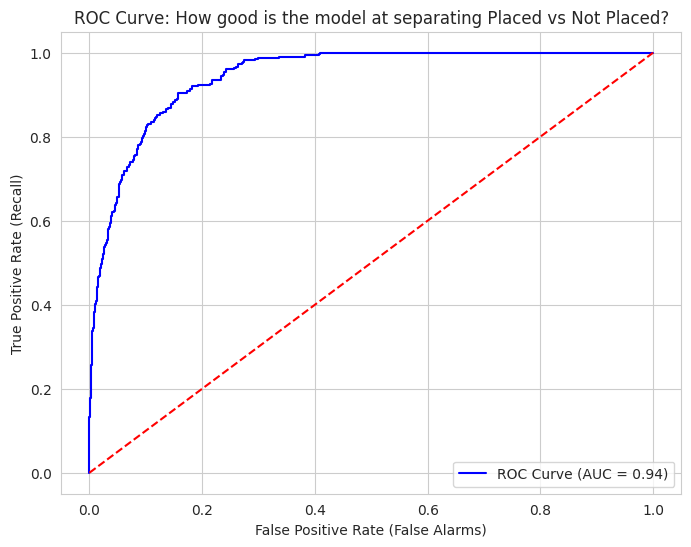

In [36]:
# 1. Get probabilities (instead of just Yes/No predictions)
# We need the probability of being "Placed" (Class 1)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# 2. Calculate the AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc_score:.4f}")

# 3. Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Random guess line
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve: How good is the model at separating Placed vs Not Placed?')
plt.legend()
plt.show()

### Findings

First is about the confusion matrix. confusion matrix shows the precision of the results of the predicted placements vs the actual placements. Here we see that our model is at 90% accurate at predicting students not placing and 61% at students placing. 

The features (or the coefficients or weights) are the x variables who may or may not have influence on the placement results of the students. And according to the results, out of the 7 features, there are 4 who have significant influence over placement results. These are Communication Skills, CGPA, IQ, and Projects Completed.

Lastly, according to the Chi test,a test that checks the significance of a Logistic Regression model, it says that our model is statistically significant because of the much help the features provides in predictions.

1. Model Performance (Reliability) Our Logistic Regression model achieved an outstanding ROC-AUC Score of 0.94. This indicates that the model is excellent at distinguishing between students who will be placed and those who won't. While the overall accuracy is 90%, the model is slightly conservative—it is highly precise (93%) when it predicts failure, but it misses some opportunities (Recall 61%), meaning it only predicts "Placed" when it is very confident.

2. Key Drivers of Placement (The "Success Factors") We analyzed the Odds Ratios to understand the magnitude of each feature's impact. The results were surprising and provide a clear hierarchy of importance:

Communication Skills is King: This was the single strongest predictor. For every 1-point increase in Communication Skills (e.g., going from a 7 to an 8), a student is 6.4 times more likely to get placed.

Academic Metrics (CGPA & IQ): These are strong followers. A 1-point increase in CGPA increases placement odds by 5.4 times, and higher IQ increases odds by 5.0 times.

Projects Matter: Completing more projects is also significant, increasing placement odds by 3.2 times per project.

3. The "Neutral" Factors Interestingly, Extra-Curricular Score and Academic Performance had Odds Ratios very close to 1.0 (~0.97). This implies that, in this specific dataset, these factors have almost no effect on whether a student gets placed or not. They are statistically neutral.

4. Conclusion The Chi-Squared test confirmed these findings are statistically significant (p < 0.05). The data suggests that to maximize placement chances, students should prioritize soft skills (Communication) and core grades (CGPA) over extra-curricular activities.